# Fitting single PSFs in 2D, example 2

* Simulated PSF based on Fourier optics model with aberations
* CNN-based encoder to extract x, y, amplitude, background,
* The model also learns a denoised verison of the PSF in 2D
* Rendered back into images based on spline interpolation

In [1]:
import os
import numpy as np
from matplotlib import pyplot

import torch
from torch import nn
from torch.utils.data import DataLoader

from torchinfo import summary

from smlm_dl import dataset, model, trainer, config, util

/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/dataset.py:441: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


2046:	 [id = 2046.000,], [A = 1165.184,], [bg = 66.755,], [x = -1.138,], [y = 5.643,], [z = 0.000,],
400:	 [id = 400.000,], [A = 757.895,], [bg = 10.546,], [x = 8.043,], [y = -1.409,], [z = 0.000,],
410:	 [id = 410.000,], [A = 1822.658,], [bg = 79.090,], [x = 7.533,], [y = -10.765,], [z = 0.000,],
757:	 [id = 757.000,], [A = 1907.678,], [bg = 63.410,], [x = 0.611,], [y = 0.765,], [z = 0.000,],
293:	 [id = 293.000,], [A = 1052.572,], [bg = 98.222,], [x = 8.182,], [y = 11.362,], [z = 0.000,],
0:	 [id = 0.000,], [A = 1569.815,], [bg = 47.531,], [x = 7.222,], [y = -7.153,], [z = 0.000,],
1663:	 [id = 1663.000,], [A = 743.855,], [bg = 94.415,], [x = 3.197,], [y = -1.443,], [z = 0.000,],
1831:	 [id = 1831.000,], [A = 548.611,], [bg = 9.077,], [x = 5.745,], [y = -9.654,], [z = 0.000,],
1422:	 [id = 1422.000,], [A = 1669.543,], [bg = 95.107,], [x = -6.357,], [y = -6.758,], [z = 0.000,],
704:	 [id = 704.000,], [A = 1648.427,], [bg = 49.786,], [x = 2.068,], [y = -0.949,], [z = 0.000,],
1008:	 [i

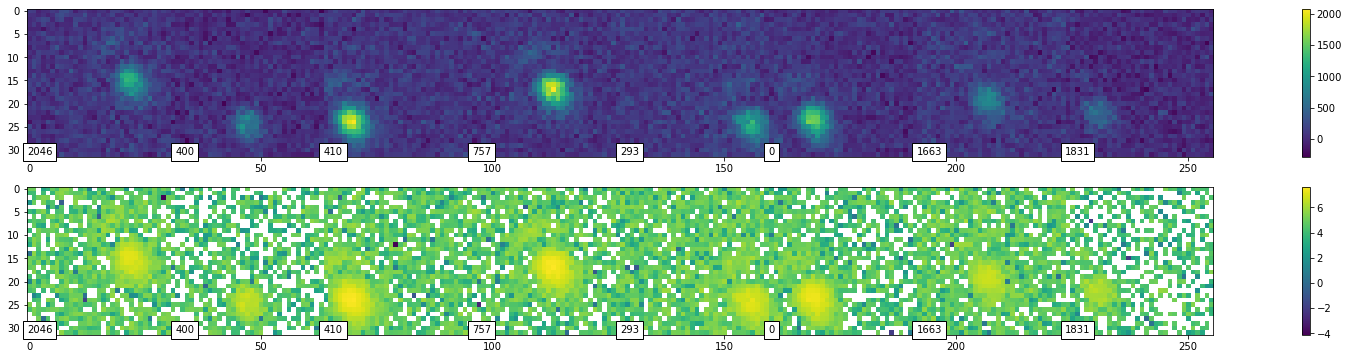

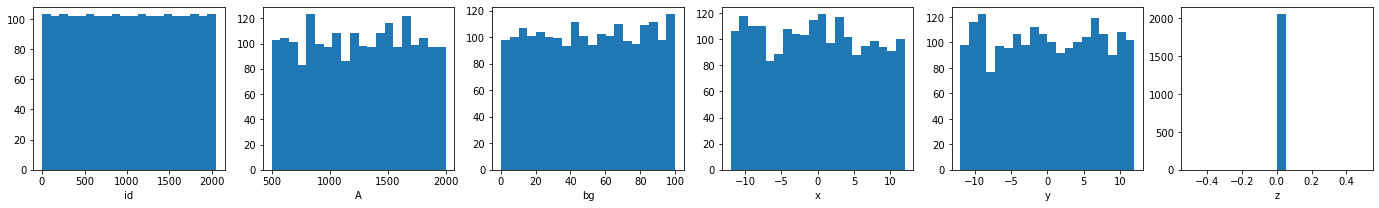

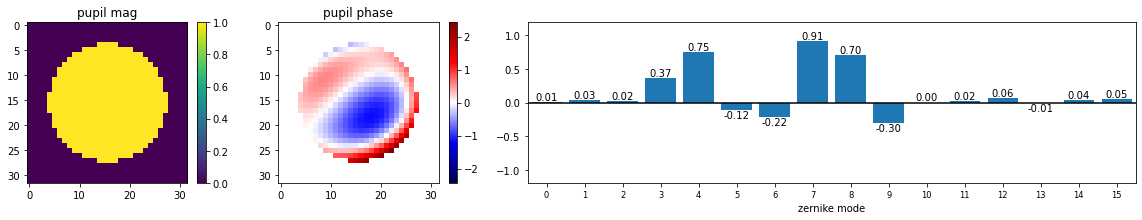

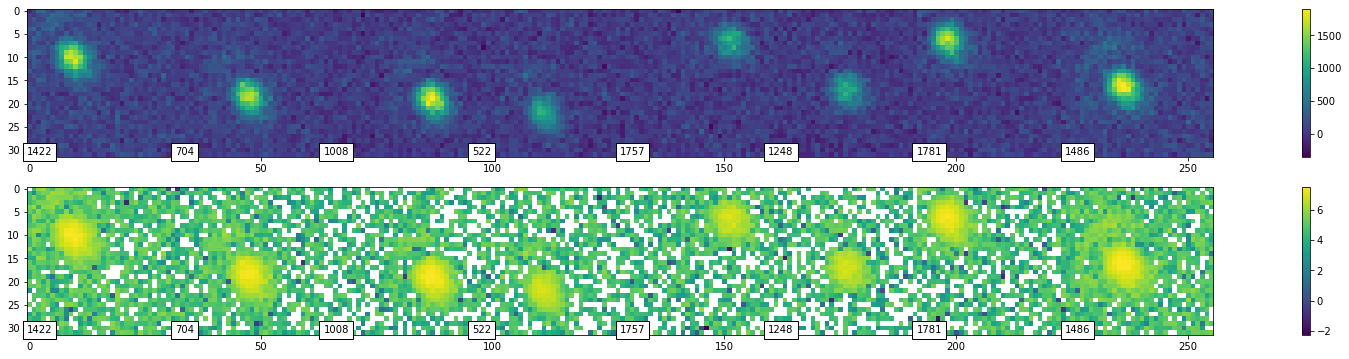

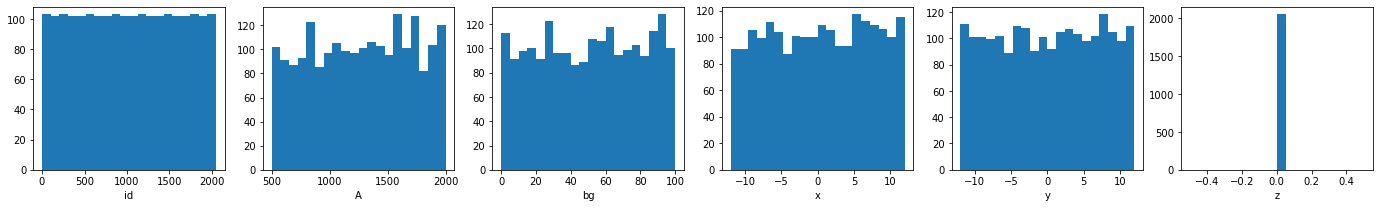

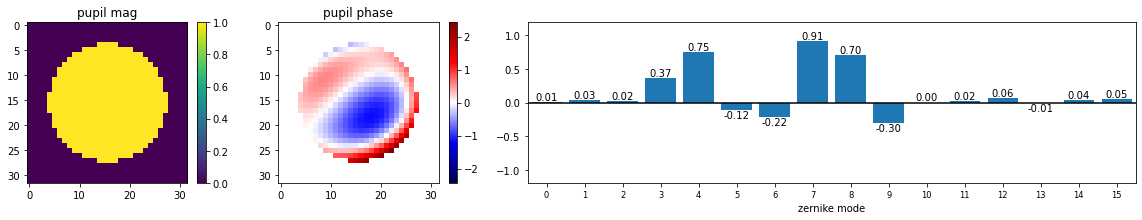

In [2]:
settings = {
    'out_size': (32,32),
    'length': (2048, 1),
    'psf_params': {'A': [500, 2000],
                   'bg': [0, 100],
                   'x': [-12, 12],
                   'y': [-12, 12],
                   'z': [0, 0]
                  },
    'psf_zerns': {key: np.random.uniform(-1,1) for key in range(3, 10)},
}

training_data = dataset.FourierOpticsPSFDataset(**settings)
training_data.to('cuda')
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=2048, shuffle=True, )

settings['length'] = (2048)
validation_data = dataset.FourierOpticsPSFDataset(**settings)
validation_data.to('cuda')
dataset.inspect_images(validation_data)
validation_dataloader = DataLoader(validation_data, batch_size=2048, shuffle=True, )

In [3]:
fitting_model = model.BaseFitModel(encoder_class=model.ConvImageEncoderModel,
                                   renderer_class=model.renderer.Spline2DRenderer,
                                   fit_params=['x','y','A','bg',],)
print(summary(fitting_model, depth=4))

  0%|          | 0/100 [00:00<?, ?it/s]

Early termination after 47 iterations, r2 tol < 0.001 reached
Final loss: 0.000	R2: 0.999
Layer (type:depth-idx)                   Param #
BaseFitModel                             --
├─DirectMapperModel: 1-1                 --
│    └─ModuleDict: 2-1                   --
├─Spline2DRenderer: 1-2                  1,600
├─ConvImageEncoderModel: 1-3             --
│    └─ModuleDict: 2-2                   --
│    │    └─Sequential: 3-1              --
│    │    │    └─Identity: 4-1           --
│    │    │    └─Conv2d: 4-2             320
│    │    │    └─ReLU: 4-3               --
│    │    │    └─Identity: 4-4           --
│    │    │    └─Conv2d: 4-5             9,248
│    │    │    └─ReLU: 4-6               --
│    │    │    └─MaxPool2d: 4-7          --
│    │    └─Sequential: 3-2              --
│    │    │    └─Identity: 4-8           --
│    │    │    └─Conv2d: 4-9             18,496
│    │    │    └─ReLU: 4-10              --
│    │    │    └─Identity: 4-11          --
│    │    │   

Device: cuda
Saved model to : /home/kkc29/scratch60/runs/2022-04-29_18-34-50_c18n07.farnam.hpc.yale.internal/model.ptm
Saved loss model : /home/kkc29/scratch60/runs/2022-04-29_18-34-50_c18n07.farnam.hpc.yale.internal/loss.ptm


  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 999. Saved to : /home/kkc29/scratch60/runs/2022-04-29_18-34-50_c18n07.farnam.hpc.yale.internal/checkpoint.ptc
input shape: (2048, 1, 32, 32), output_shape: (2048, 1, 32, 32)


/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/model/base.py:151: RuntimeWarning: invalid value encountered in log10
  im = axes[0, i].imshow(np.log10(img))


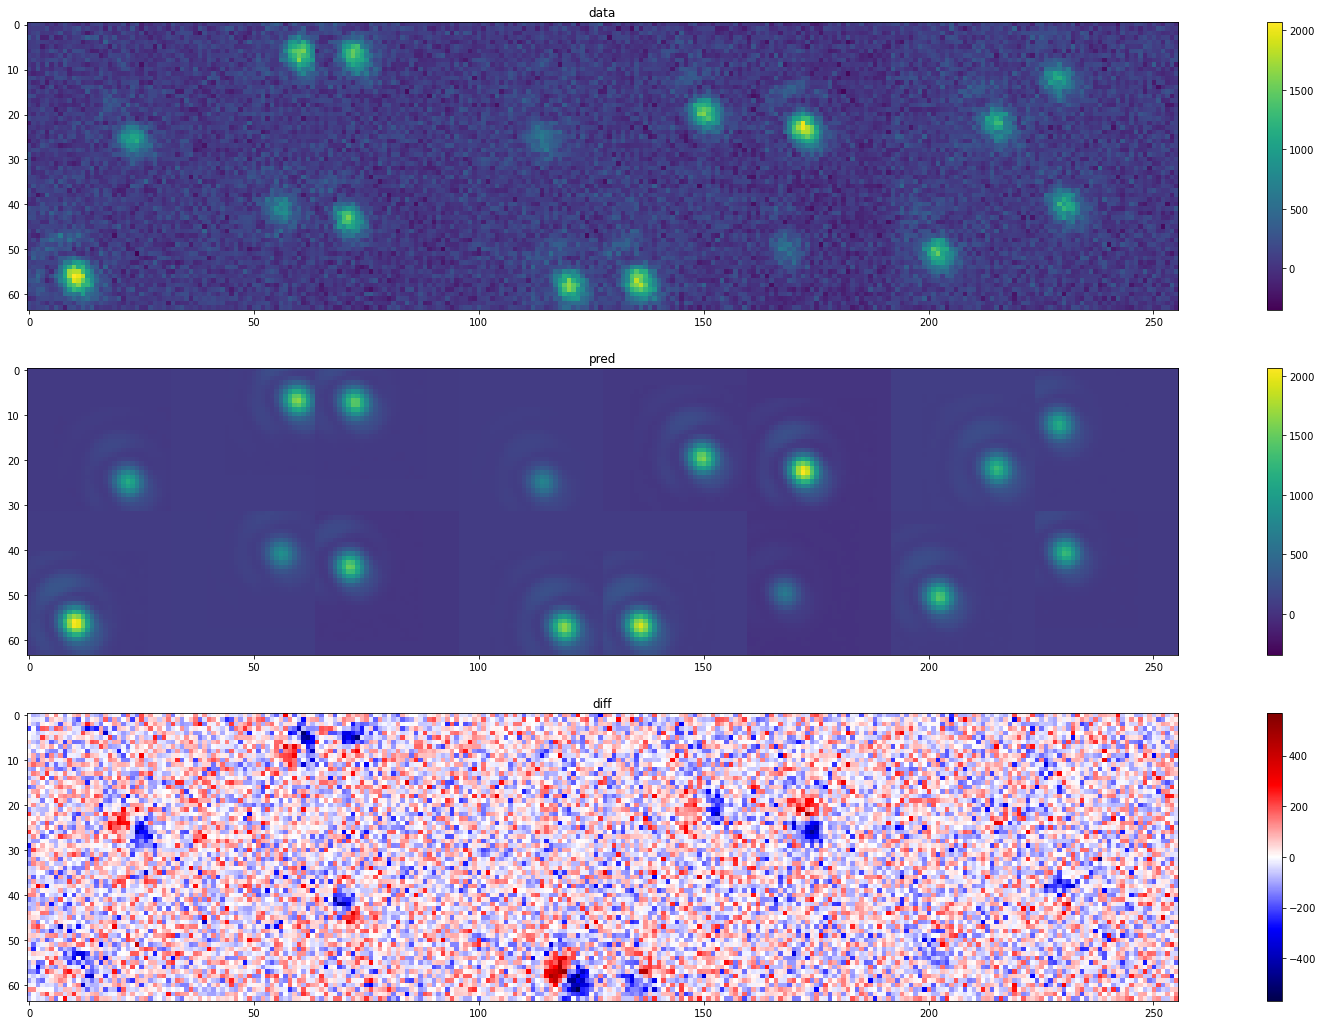

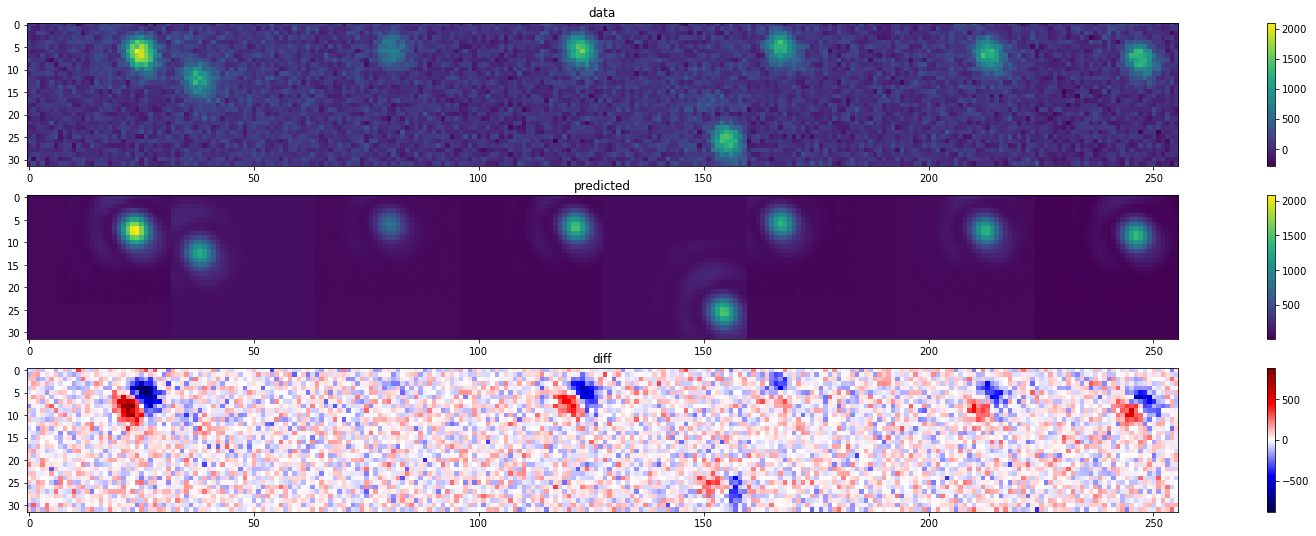

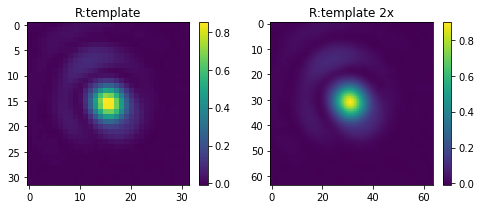

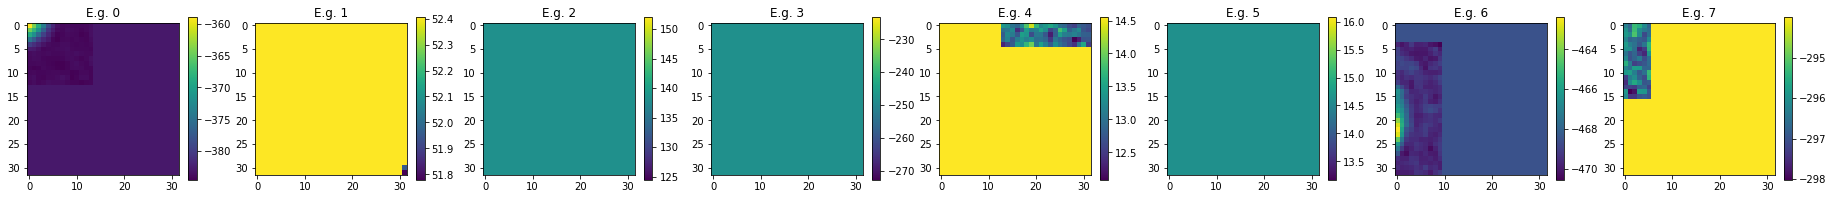

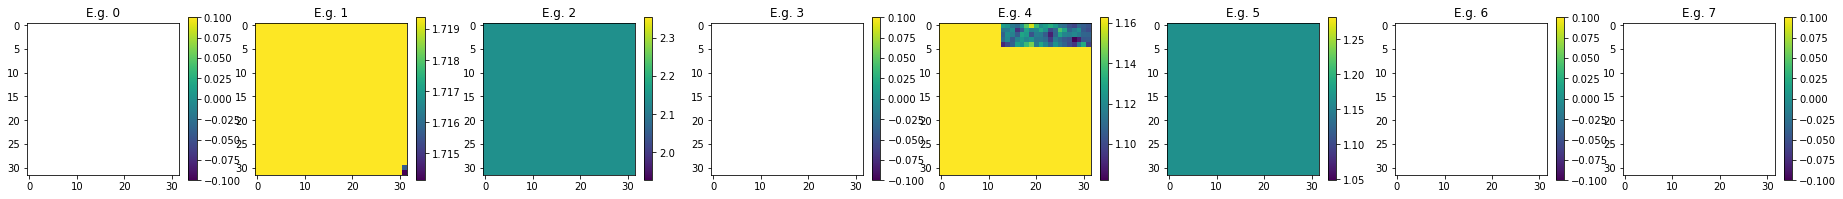

In [4]:
dict_log = {}
training = trainer.FittingTrainer(fitting_model, train_dataloader, validation_dataloader,)
training.train_and_validate(1000, 10, 100, tb_logger=True, dict_log=dict_log)
model.check_model(fitting_model, train_dataloader)

/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/trainer.py:432: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale("log")
/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/trainer.py:432: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale("log")


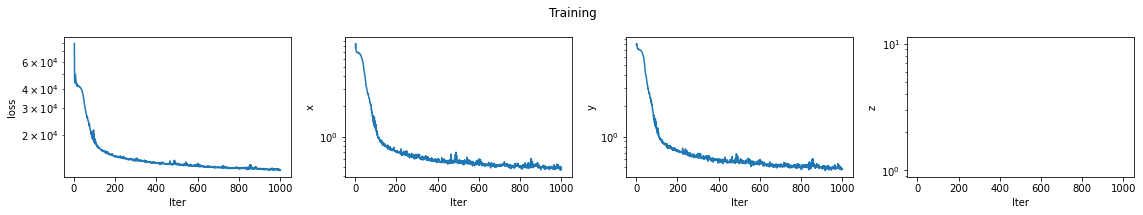

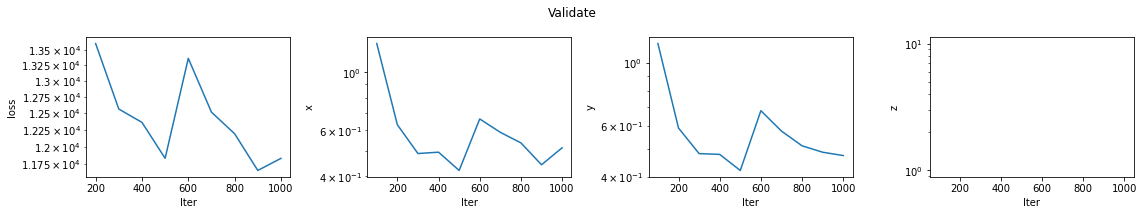

In [5]:
plots = trainer.inspect_dict_log(dict_log, log=True)